In [1]:
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
import os
import csv
import random
import numpy as np

import time
 
from tqdm import tqdm 

from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold

from tensorflow.keras import backend as K

2025-03-22 04:46:10.259015: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-22 04:46:10.259071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-22 04:46:10.260033: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-22 04:46:10.265376: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-22 04:46:10.829653: W tensorflow/compiler/tf2

In [2]:
num_classes = 1
k = 5


IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

DATA_PATH = 'data/'

data_ids = next(os.walk(DATA_PATH+'/image'))[2]

X = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

# Definição do diretório de saída
output_dir = "UNet3Plus DICE 5-fold model"
os.makedirs(output_dir, exist_ok=True)  # Garante que a pasta existe

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR']= 'cuda_malloc_async'


In [3]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):   
    path = DATA_PATH
    img = imread(path + '/image/' + id_)[:,:]
    img = img.reshape(img.shape[0], img.shape[1], IMG_CHANNELS)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    
    mask = imread(path + 'label/' + id_)
    mask = (mask >= 250)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
    y[n] = mask 
    #plt.axis("off")
    #imshow(y[n])
    #plt.show()

Resizing training images and masks


100%|█████████████████████████████████████████████████████████████████████████████████| 838/838 [00:20<00:00, 40.71it/s]


In [4]:
@tf.keras.utils.register_keras_serializable()
def f1_score(y_true, y_pred):
    """Calcula o F1-Score para segmentação binária"""
    y_pred = K.round(y_pred)  # Arredondar para 0 ou 1
    tp = K.sum(K.cast(y_true * y_pred, 'float32'))  # Verdadeiros Positivos
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float32'))  # Falsos Positivos
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float32'))  # Falsos Negativos
    
    precision = tp / (tp + fp + K.epsilon())  # Precision
    recall = tp / (tp + fn + K.epsilon())  # Recall
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())  # F1-Score
    return f1

In [5]:
@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

In [6]:
from tensorflow.keras.layers import Conv2D, Dropout, BatchNormalization, ReLU, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import tensorflow as tf

def unet_3_plus():
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    def conv_block(x, filters, dropout=0.1):
        x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(dropout)(x)
        x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)
        return ReLU()(x)
    
    # Encoder
    c1 = conv_block(inputs, 16)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = conv_block(p1, 32)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = conv_block(p2, 64, dropout=0.2)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = conv_block(p3, 128, dropout=0.2)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = conv_block(p4, 256, dropout=0.3)
    
    # Decoder - UNet3+
    def upsample_concat(filters, source, *targets):
        upsample = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(source)
        return concatenate([upsample] + list(targets))
    
    # Decoder 4 (H/8)
    d5_to_d4 = upsample_concat(256, c5, c4)
    d4 = conv_block(d5_to_d4, 128)
    
    # Decoder 3 (H/4)
    d4_to_d3 = upsample_concat(128, d4, c3)
    d3 = conv_block(d4_to_d3, 64)
    
    # Decoder 2 (H/2)
    d3_to_d2 = upsample_concat(64, d3, c2)
    d2 = conv_block(d3_to_d2, 32)
    
    # Decoder 1 (Full resolution)
    d2_to_d1 = upsample_concat(32, d2, c1)
    d1 = conv_block(d2_to_d1, 16)
    
    # Deep supervision (opcional)
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(d1)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=dice_loss, metrics=[
        'accuracy', 
        tf.keras.metrics.Recall(name='recall'), 
        tf.keras.metrics.Precision(name='precision'),
        f1_score,
        tf.keras.metrics.IoU(num_classes=2, target_class_ids={0,1}, name='IoU')
    ])
    
    return model

In [7]:
acc = []
jacc = []
f1 = []
prec = []
rec = []

# Dicionário para armazenar métricas por fold
fold_metrics_summary = []

kf = KFold(n_splits=k, shuffle=True, random_state=28)
fold = 4

for i, (train_ind, test_ind) in enumerate(kf.split(X)):
    if i < (fold-1):
        continue
    
    
    print("Fold: " + str(fold))
    X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]

    model = unet_3_plus()
    
    
    checkpoint_filepath = os.path.join(output_dir, f'model_{fold}fold.keras')
    callbacks = [
            tf.keras.callbacks.TensorBoard(log_dir='logs'),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=False,
                monitor='val_f1_score',
                mode='max',
                save_best_only=True,
                verbose=1)]
    
    start_time = time.time()
    model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=16, epochs=150, callbacks=callbacks)
    end_time = time.time()
    training_time = end_time - start_time

     # Salvando o tempo de treinamento
    with open(os.path.join(output_dir, 'training_time.txt'), 'a') as f:
        f.write(f'Fold {fold}: {training_time:.2f} segundos\n')
    print(f"O modelo demorou {training_time:.2f} segundos para treinar.")
    
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    
    with open(os.path.join(output_dir, f'loss_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Epoch", "Loss", "Validation Loss"])
        for epoch, (l, vl) in enumerate(zip(loss, val_loss), start=1):
            writer.writerow([epoch, l, vl])
            
     # Plotando e salvando a figura
    plt.figure()
    plt.plot(loss, 'r', label='Training loss')
    plt.plot(val_loss, 'g', label='Validation loss')
    plt.title(f'Training and Validation Loss - Fold {fold}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.ylim([0, 1])
    plt.legend()
    plt.savefig(os.path.join(output_dir, f'loss_plot_fold{fold}.png'))
    plt.close()


    fold_metrics = []

    acc_fold = []
    jacc_fold = []
    f1_fold = []
    prec_fold = []
    rec_fold = []
    
    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
            
        acc_score = accuracy_score(sample_mask, predicted_mask)
        jacc_score = jaccard_score(sample_mask, predicted_mask)
        f1_score_val = f1_score(sample_mask, predicted_mask).numpy()
        prec_score = precision_score(sample_mask, predicted_mask)
        rec_score = recall_score(sample_mask, predicted_mask)

        acc_fold.append(acc_score)
        jacc_fold.append(jacc_score)
        f1_fold.append(f1_score_val)
        prec_fold.append(prec_score)
        rec_fold.append(rec_score)

        fold_metrics.append([i, acc_score, jacc_score, f1_score_val, prec_score, rec_score])
        
    # Salvando métricas por imagem
    with open(os.path.join(output_dir, f'metrics_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Index", "Accuracy", "Jaccard", "DICE", "Precision", "Recall"])
        writer.writerows(fold_metrics)

    # Salvando a média do fold para cada métrica
    fold_metrics_summary.append([
        fold, np.mean(acc_fold), np.std(acc_fold),
        np.mean(jacc_fold), np.std(jacc_fold),
        np.mean(f1_fold), np.std(f1_fold),
        np.mean(prec_fold), np.std(prec_fold),
        np.mean(rec_fold), np.std(rec_fold)
    ])

        
    del model 

    tf.keras.backend.clear_session()

    fold+=1
    
# Calculando médias gerais
acc_total = [m[1] for m in fold_metrics_summary]
jacc_total = [m[3] for m in fold_metrics_summary]
f1_total = [m[5] for m in fold_metrics_summary]
prec_total = [m[7] for m in fold_metrics_summary]
rec_total = [m[9] for m in fold_metrics_summary]

general_summary = [
    ["Fold", "Accuracy Mean", "Accuracy Std", "Jaccard Mean", "Jaccard Std",
     "DICE Mean", "DICE Std", "Precision Mean", "Precision Std", "Recall Mean", "Recall Std"]
]

general_summary.extend(fold_metrics_summary)

general_summary.append([
    "Overall Mean", np.mean(acc_total), np.std(acc_total),
    np.mean(jacc_total), np.std(jacc_total),
    np.mean(f1_total), np.std(f1_total),
    np.mean(prec_total), np.std(prec_total),
    np.mean(rec_total), np.std(rec_total)
])

# Salvando o resumo das métricas por fold e geral
with open(os.path.join(output_dir, 'metrics_summary.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    writer.writerows(general_summary)

print("Métricas salvas com sucesso na pasta:", output_dir)

Fold: 4


2025-03-22 04:46:32.900030: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-22 04:46:32.924673: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-22 04:46:32.924721: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-22 04:46:32.927490: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-22 04:46:32.927544: I external/local_xla/xla/stream_executor

Epoch 1/150


2025-03-22 04:46:36.700126: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-03-22 04:46:37.095579: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-03-22 04:46:42.211602: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f953ea2a930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-22 04:46:42.211637: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-03-22 04:46:42.216280: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742629602.281117  743130 device_compiler.h:186] Compiled cluster using XLA!  T

42/42 [==============================] - ETA: 0s - loss: 0.9971 - accuracy: 0.7641 - recall: 0.9482 - precision: 0.0026 - f1_score: 0.0072 - IoU: 0.5144
Epoch 1: val_f1_score improved from -inf to 0.00159, saving model to UNet3Plus DICE 5-fold model/model_4fold.keras
42/42 [==============================] - 64s 881ms/step - loss: 0.9971 - accuracy: 0.7641 - recall: 0.9482 - precision: 0.0026 - f1_score: 0.0072 - IoU: 0.5144 - val_loss: 0.9985 - val_accuracy: 0.2957 - val_recall: 1.0000 - val_precision: 8.2987e-04 - val_f1_score: 0.0016 - val_IoU: 0.1981
Epoch 2/150
42/42 [==============================] - ETA: 0s - loss: 0.9940 - accuracy: 0.9799 - recall: 0.9910 - precision: 0.0305 - f1_score: 0.0663 - IoU: 0.5546
Epoch 2: val_f1_score improved from 0.00159 to 0.00180, saving model to UNet3Plus DICE 5-fold model/model_4fold.keras
42/42 [==============================] - 14s 331ms/step - loss: 0.9940 - accuracy: 0.9799 - recall: 0.9910 - precision: 0.0305 - f1_score: 0.0663 - IoU: 0.55

2025-03-22 05:21:40.626953: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


42/42 [==============================] - ETA: 0s - loss: 0.9972 - accuracy: 0.7546 - recall: 0.9504 - precision: 0.0025 - f1_score: 0.0051 - IoU: 0.5000
Epoch 1: val_f1_score improved from -inf to 0.00206, saving model to UNet3Plus DICE 5-fold model/model_5fold.keras
42/42 [==============================] - 20s 344ms/step - loss: 0.9972 - accuracy: 0.7546 - recall: 0.9504 - precision: 0.0025 - f1_score: 0.0051 - IoU: 0.5000 - val_loss: 0.9982 - val_accuracy: 0.4535 - val_recall: 1.0000 - val_precision: 0.0011 - val_f1_score: 0.0021 - val_IoU: 0.3642
Epoch 2/150
42/42 [==============================] - ETA: 0s - loss: 0.9942 - accuracy: 0.9744 - recall: 0.9875 - precision: 0.0240 - f1_score: 0.0657 - IoU: 0.5452
Epoch 2: val_f1_score improved from 0.00206 to 0.00486, saving model to UNet3Plus DICE 5-fold model/model_5fold.keras
42/42 [==============================] - 14s 331ms/step - loss: 0.9942 - accuracy: 0.9744 - recall: 0.9875 - precision: 0.0240 - f1_score: 0.0657 - IoU: 0.5452 -

2025-03-22 05:40:48.248365: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 1074861327 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 631242752/12878086144
2025-03-22 05:40:48.248405: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                     10022289408
InUse:                      7197959241
MaxInUse:                  11038268409
NumAllocs:                     6241688
MaxAllocSize:               6845546512
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2025-03-22 05:40:48.248464: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2025-03-22 05:40:48.248468: E external/local_xla/xla/stream_executor

42/42 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 1.0000 - recall: 0.9724 - precision: 0.9718 - f1_score: 0.9720 - IoU: 0.9614
Epoch 83: val_f1_score did not improve from 0.98490
42/42 [==============================] - 15s 361ms/step - loss: 0.0284 - accuracy: 1.0000 - recall: 0.9724 - precision: 0.9718 - f1_score: 0.9720 - IoU: 0.9614 - val_loss: 0.0278 - val_accuracy: 1.0000 - val_recall: 0.9773 - val_precision: 0.9802 - val_f1_score: 0.9732 - val_IoU: 0.9671
Epoch 84/150
42/42 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 1.0000 - recall: 0.9753 - precision: 0.9695 - f1_score: 0.9716 - IoU: 0.9629
Epoch 84: val_f1_score did not improve from 0.98490
42/42 [==============================] - 15s 367ms/step - loss: 0.0288 - accuracy: 1.0000 - recall: 0.9753 - precision: 0.9695 - f1_score: 0.9716 - IoU: 0.9629 - val_loss: 0.0304 - val_accuracy: 1.0000 - val_recall: 0.9549 - val_precision: 0.9893 - val_f1_score: 0.9712 - val_IoU: 0.9536
E

2025-03-22 05:43:52.333775: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 1074861327 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 631242752/12878086144
2025-03-22 05:43:52.333815: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                     10022289408
InUse:                      7197959753
MaxInUse:                  11038268409
NumAllocs:                     6572544
MaxAllocSize:               6845546512
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2025-03-22 05:43:52.333878: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2025-03-22 05:43:52.333882: E external/local_xla/xla/stream_executor

42/42 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 1.0000 - recall: 0.9764 - precision: 0.9749 - f1_score: 0.9754 - IoU: 0.9657
Epoch 95: val_f1_score did not improve from 0.98490
42/42 [==============================] - 14s 342ms/step - loss: 0.0249 - accuracy: 1.0000 - recall: 0.9764 - precision: 0.9749 - f1_score: 0.9754 - IoU: 0.9657 - val_loss: 0.0201 - val_accuracy: 1.0000 - val_recall: 0.9731 - val_precision: 0.9893 - val_f1_score: 0.9803 - val_IoU: 0.9652
Epoch 96/150
42/42 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 1.0000 - recall: 0.9777 - precision: 0.9744 - f1_score: 0.9754 - IoU: 0.9664
Epoch 96: val_f1_score did not improve from 0.98490
42/42 [==============================] - 16s 383ms/step - loss: 0.0249 - accuracy: 1.0000 - recall: 0.9777 - precision: 0.9744 - f1_score: 0.9754 - IoU: 0.9664 - val_loss: 0.0166 - val_accuracy: 1.0000 - val_recall: 0.9857 - val_precision: 0.9853 - val_f1_score: 0.9838 - val_IoU: 0.9746
E

2025-03-22 05:48:09.648789: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 1074861327 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 396361728/12878086144
2025-03-22 05:48:09.648829: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                     10022289408
InUse:                      7197960461
MaxInUse:                  11038268409
NumAllocs:                     7005758
MaxAllocSize:               6845546512
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2025-03-22 05:48:09.648886: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2025-03-22 05:48:09.648889: E external/local_xla/xla/stream_executor

42/42 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 1.0000 - recall: 0.9793 - precision: 0.9753 - f1_score: 0.9760 - IoU: 0.9684
Epoch 112: val_f1_score improved from 0.98490 to 0.98522, saving model to UNet3Plus DICE 5-fold model/model_5fold.keras
42/42 [==============================] - 15s 369ms/step - loss: 0.0243 - accuracy: 1.0000 - recall: 0.9793 - precision: 0.9753 - f1_score: 0.9760 - IoU: 0.9684 - val_loss: 0.0152 - val_accuracy: 1.0000 - val_recall: 0.9897 - val_precision: 0.9853 - val_f1_score: 0.9852 - val_IoU: 0.9804
Epoch 113/150
42/42 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 1.0000 - recall: 0.9788 - precision: 0.9743 - f1_score: 0.9747 - IoU: 0.9687
Epoch 113: val_f1_score did not improve from 0.98522
42/42 [==============================] - 14s 345ms/step - loss: 0.0256 - accuracy: 1.0000 - recall: 0.9788 - precision: 0.9743 - f1_score: 0.9747 - IoU: 0.9687 - val_loss: 0.0361 - val_accuracy: 1.0000 - val_recall: 0.9

/home/mbouzon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Métricas salvas com sucesso na pasta: UNet3Plus DICE 5-fold model


In [8]:
acc_mean_fold = []
jacc_mean_fold = []
f1_mean_fold = []
prec_mean_fold = []
rec_mean_fold = []

acc_std_fold = []
jacc_std_fold = []
f1_std_fold = []
prec_std_fold = []
rec_std_fold = []


# Dicionário para armazenar métricas por fold
fold_metrics_summary = []

fold = 1
kf = KFold(n_splits=k, shuffle=True, random_state=28)
for train_ind, test_ind in tqdm(kf.split(X), total=kf.get_n_splits(), desc="k-fold"):
    X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]

    fold_metrics = []

    acc_fold = []
    jacc_fold = []
    f1_fold = []
    prec_fold = []
    rec_fold = []
    
    model_filepath = filepath = os.path.join(output_dir, f'model_{fold}fold.keras')
    model = tf.keras.models.load_model(model_filepath)

    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
            
        acc_score = accuracy_score(sample_mask, predicted_mask)
        jacc_score = jaccard_score(sample_mask, predicted_mask)
        f1_score_val = f1_score(sample_mask, predicted_mask).numpy()
        prec_score = precision_score(sample_mask, predicted_mask)
        rec_score = recall_score(sample_mask, predicted_mask)

        acc_fold.append(acc_score)
        jacc_fold.append(jacc_score)
        f1_fold.append(f1_score_val)
        prec_fold.append(prec_score)
        rec_fold.append(rec_score)

        fold_metrics.append([i, acc_score, jacc_score, f1_score_val, prec_score, rec_score])
        
    # Salvando métricas por imagem
    with open(os.path.join(output_dir, f'metrics_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Index", "Accuracy", "Jaccard", "DICE", "Precision", "Recall"])
        writer.writerows(fold_metrics)

    # Salvando a média do fold para cada métrica
    fold_metrics_summary.append([
        fold, np.mean(acc_fold), np.std(acc_fold),
        np.mean(jacc_fold), np.std(jacc_fold),
        np.mean(f1_fold), np.std(f1_fold),
        np.mean(prec_fold), np.std(prec_fold),
        np.mean(rec_fold), np.std(rec_fold)
    ])


    fold += 1

# Calculando médias gerais
acc_total = [m[1] for m in fold_metrics_summary]
jacc_total = [m[3] for m in fold_metrics_summary]
f1_total = [m[5] for m in fold_metrics_summary]
prec_total = [m[7] for m in fold_metrics_summary]
rec_total = [m[9] for m in fold_metrics_summary]

general_summary = [
    ["Fold", "Accuracy Mean", "Accuracy Std", "Jaccard Mean", "Jaccard Std",
     "DICE Mean", "DICE Std", "Precision Mean", "Precision Std", "Recall Mean", "Recall Std"]
]

general_summary.extend(fold_metrics_summary)

general_summary.append([
    "Overall Mean", np.mean(acc_total), np.std(acc_total),
    np.mean(jacc_total), np.std(jacc_total),
    np.mean(f1_total), np.std(f1_total),
    np.mean(prec_total), np.std(prec_total),
    np.mean(rec_total), np.std(rec_total)
])

# Salvando o resumo das métricas por fold e geral
with open(os.path.join(output_dir, 'metrics_summary.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    writer.writerows(general_summary)

print("Métricas salvas com sucesso na pasta:", output_dir)

k-fold:  80%|█████████████████████████████████████████████████████████████▌               | 4/5 [01:57<00:29, 29.24s/it]/home/mbouzon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
k-fold: 100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [02:26<00:00, 29.34s/it]

Métricas salvas com sucesso na pasta: UNet3Plus DICE 5-fold model


In [9]:
print("Accuracy: "+ str(np.mean(acc_total)*100) + " +- " + str(np.std(acc_total)*100))
print("Jaccard: "+ str(np.mean(jacc_total)*100) + " +- " + str(np.std(jacc_total)*100))
print("Dice: "+ str(np.mean(f1_total)*100) + " +- " + str(np.std(f1_total)*100))
print("Precision: "+ str(np.mean(prec_total)*100) + " +- " + str(np.std(prec_total)*100))
print("Recall: "+ str(np.mean(rec_total)*100) + " +- " + str(np.std(rec_total)*100))

Accuracy: 99.99782324857034 +- 0.0008071275615491656
Jaccard: 95.10345249018283 +- 0.4898797640848829
Dice: 97.20045328140259 +- 0.19569597207009792
Precision: 97.48635566998483 +- 0.21846919897463968
Recall: 97.3522914423454 +- 0.416591583982813


In [10]:
best_fold = 2
best_model_filepath = filepath = os.path.join(output_dir, f'model_{best_fold}fold.keras')
best_model = tf.keras.models.load_model(best_model_filepath)

In [11]:
kf = KFold(n_splits=k, shuffle=True, random_state=28)
for i, (train_ind, test_ind) in enumerate(kf.split(X)):
    if i == (best_fold-1):
        X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]
        break

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
    plt.axis('off')
  plt.show()
  

1/1 [==============================] - 0s 178ms/step


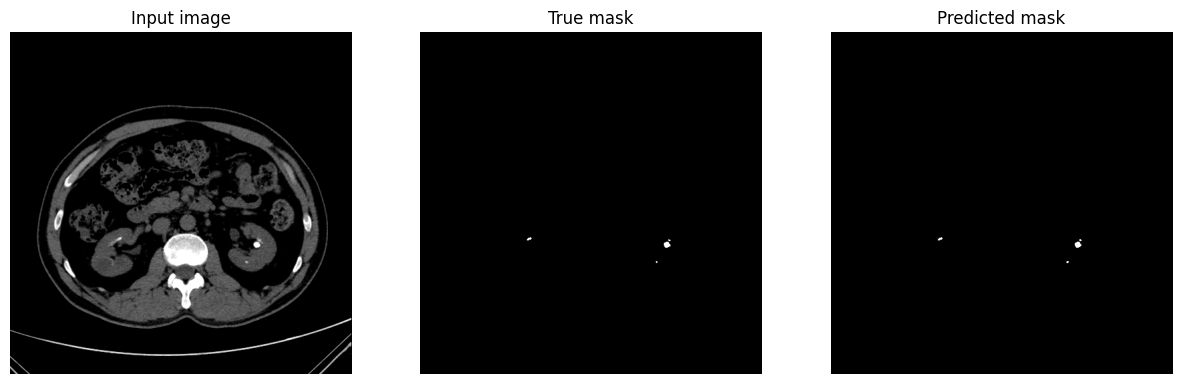

Accuracy: 0.9999809265136719
Jaccard: 0.9528301886792453
Dice: 0.9758454106280194
Precision: 0.9619047619047619
Recall: 0.9901960784313726


In [13]:
i = random.randint(0, len(X_val))
sample_image = X_val[i]
sample_mask = y_val[i]
prediction = best_model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
display([sample_image, sample_mask,predicted_mask])

sample_mask = y_val[i].astype(np.uint8).flatten()
predicted_mask = predicted_mask.flatten()


print("Accuracy: "+ str(accuracy_score(sample_mask, predicted_mask)))
print("Jaccard: "+ str(jaccard_score(sample_mask, predicted_mask)))
print("Dice: "+ str((2*jaccard_score(sample_mask, predicted_mask))/(1+jaccard_score(sample_mask, predicted_mask))))
print("Precision: "+ str(precision_score(sample_mask, predicted_mask)))
print("Recall: "+ str(recall_score(sample_mask, predicted_mask)))